[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/donishadsmith/neurocaps/blob/stable/demos/simulated_demo.ipynb)

<font size="6">Logging</font>

 <font size="3">Default logging configurations are provided by NeuroCAPs, which sends logged messages to standard output. However, optionally, logging can be configured prior to package import. For more information about configuring logging, , especially for logging with parallel processing, refer to [NeuroCAPs' Logging Documentation](https://neurocaps.readthedocs.io/en/stable/logging.html).</font>

In [1]:
import logging

try:
    from rich.logging import RichHandler

    handler = RichHandler()
except:
    import sys

    handler = logging.StreamHandler(sys.stdout)


logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(name)s [%(levelname)s] %(message)s",
    handlers=[handler],
)

In [2]:
# Download packages
try:
    import neurocaps
except:
    !pip install neurocaps[windows,demo]

# Set headless display for google colab
import os, sys

if "google.colab" in sys.modules:
    os.environ["DISPLAY"] = ":0.0"
    !apt-get install -y xvfb
    !Xvfb :0 -screen 0 1024x768x24 &> /dev/null &
    !Xvfb :0 -screen 0 1024x768x24 &> /dev/null &

<font size="6">Imports & Example Dataset</font>

 <font size="3">Import packages necessary for the demo to run and download example dataset ([OpenfMRI database, accession number ds000031](https://openfmri.org/dataset/ds000031/)) used in a few demonstrations.</font>

In [3]:
import os, subprocess, sys
import plotly.io as pio

import numpy as np, joblib

# To show static plotly images so that they can be displayed on the saved Jupyter notebook on Github
pio.renderers.default = "svg"

neurocaps_demo_dir = "neurocaps_demo"

os.makedirs(neurocaps_demo_dir, exist_ok=True)

curr_dir = os.path.dirname(os.getcwd())

# Bids directory
bids_dir = os.path.join(curr_dir, "tests", "data", "dset")

if not os.path.exists(bids_dir):
    if sys.platform != "win32":
        cmd = (
            "cd neurocaps_demo && "
            "git clone --depth 1 --filter=blob:none --sparse https://github.com/donishadsmith/neurocaps.git && "
            "cd neurocaps && "
            "git sparse-checkout set tests/data/dset &&"
            "git submodule update --init --depth 1 -- tests/data"
        )

        os.system(cmd)
    else:
        neurocaps_repo_dir = os.path.join(neurocaps_demo_dir, "neurocaps")

        # Enable git longpath
        subprocess.run(
            ["git", "config", "--global", "core.longpaths", "true"],
            check=True,
        )

        subprocess.run(
            [
                "git",
                "clone",
                "--depth",
                "1",
                "--filter=blob:none",
                "--sparse",
                "https://github.com/donishadsmith/neurocaps.git",
            ],
            check=True,
            cwd=neurocaps_demo_dir,
        )

        subprocess.run(
            ["git", "submodule", "update", "--init", "--depth", "1", "--", "tests/data"],
            check=True,
            cwd=neurocaps_repo_dir,
        )

    # Rename folder
    os.makedirs("neurocaps_demo/data", exist_ok=True)

    if not os.path.exists("neurocaps_demo/data/dset"):
        os.rename("neurocaps_demo/neurocaps/tests/data/dset", "neurocaps_demo/data/dset")

    bids_dir = "neurocaps_demo/data/dset"

<font size="6">Timeseries Extraction</font>

 <font size="3">To demonstrate timeseries extraction using the `TimeseriesExtractor` class, the single subject dataset used to test the NeuroCAPs package will be downloaded for demonstration. For the timeseries extraction to work, the PyBIDS package must be installed. To install PyBIDS on Windows, you can use `pip install pybids`
 or `pip install neurocaps[windows]`. Additionally, for PyBIDS installation on Windows, you may need to enable long path support. The instructions to do so, involves right clicking on Powershell, selecting "Run as Administrator", and pasting in the Powershell command located in the official [Microsoft documentation](https://learn.microsoft.com/en-us/windows/win32/fileio/maximum-file-path-limitation?tabs=powershell). An alternative involves installing [Windows Subsytem for Linux (WSL)](https://code.visualstudio.com/docs/remote/wsl-tutorial) and [opening jupyter notebook from the Ubuntu terminal](https://saturncloud.io/blog/how-to-install-jupyter-notebook-in-ubuntu/). </font>

In [4]:
from neurocaps.extraction import TimeseriesExtractor
from neurocaps.analysis import CAP, merge_dicts, standardize, change_dtype

# Can use atlases in Schaefer and AAL
parcel_approach = {"Schaefer": {"n_rois": 100}}
# parcel_approach = {"AAL": {"version": "SPM12"}}

ncol = (
    parcel_approach["Schaefer"]["n_rois"]
    if "Schaefer" in parcel_approach.keys()
    else (116 if parcel_approach["AAL"]["version"] != "3v2" else 166)
)

# If there are multiple pipelines in derivatives folder or the pipeline is nested, then pipeline_name should be used
pipeline_name = "fmriprep_1.0.0/fmriprep"

# Adding an asterisk results in all columns starting with name preceding the asterisk to be extracted for nuisance regression
confounds = ["cosine*", "rot*"]

# Set up signal cleaning parameters
extractor = TimeseriesExtractor(
    space="MNI152NLin2009cAsym",
    parcel_approach=parcel_approach,
    standardize=False,
    use_confounds=True,
    low_pass=0.15,
    confound_names=confounds,
    dummy_scans=5,
    fd_threshold={"threshold": 0.35, "outlier_percentage": 0.30, "interpolate": True},
)

# Perform the timeseries extraction; only one session can be extracted at a time. Internally, lru_cache is used for
# ``BidsLayout``. May need to clear cache if the cell was ran before the directory download completed
extractor.get_bold(
    bids_dir=bids_dir,
    session="002",
    runs="001",
    task="rest",
    pipeline_name=pipeline_name,
    n_cores=None,
    flush=False,
    tr=1.2,
    verbose=True,
    progress_bar=True,
)

# Standardize extracted timeseries of all subjects in ``extractor.subject_timeseries`` if not done in ``TimeseriesExtractor``
subject_timeseries_dict = standardize(
    subject_timeseries_list=[extractor.subject_timeseries], return_dicts=True
)

# Increase or decrease the dtype; recommend not going lower than float32; this function is intended to decrease `subject_timeseries`
# from float64 to float32 for memory saving purposes while maintaining precision.
subject_timeseries_dict = change_dtype(
    subject_timeseries_list=[subject_timeseries_dict["dict_0"]], dtype="float32"
)

# extractor.subject_timeseries is also a setter
extractor.subject_timeseries = subject_timeseries_dict["dict_0"]

[06/13/25 05:45:27] WARNING  2025-06-13 05:45:27,504                                   ]8;id=989921;file://C:\Users\donis\Github\neurocaps\neurocaps\_utils\check_parcel_approach.py\check_parcel_approach.py]8;;\:]8;id=860373;file://C:\Users\donis\Github\neurocaps\neurocaps\_utils\check_parcel_approach.py#176\176]8;;\
                             neurocaps._utils.check_parcel_approach [WARNING]                                      
                             'yeo_networks' not specified in `parcel_approach`.                                    
                             Defaulting to 7 networks.                                                             

                    WARNING  2025-06-13 05:45:27,531                                   ]8;id=410783;file://C:\Users\donis\Github\neurocaps\neurocaps\_utils\check_parcel_approach.py\check_parcel_approach.py]8;;\:]8;id=455381;file://C:\Users\donis\Github\neurocaps\neurocaps\_utils\check_parcel_approach.py#180\180]8;;\
                             neurocaps._utils.check_parcel_approach [WARNING]                                      
                             'resolution_mm' not specified in `parcel_approach`.                                   
                             Defaulting to 1mm.                                                                    

                    INFO     2025-06-13 05:45:27,544                                     ]8;id=694356;file://C:\Users\donis\Github\neurocaps\neurocaps\_utils\extraction\check_confound_names.py\check_confound_names.py]8;;\:]8;id=179525;file://C:\Users\donis\Github\neurocaps\neurocaps\_utils\extraction\check_confound_names.py#66\66]8;;\
                             neurocaps._utils.extraction.check_confound_names [INFO]                               
                             Confound regressors to be used if available: cosine*, rot*.                           

[06/13/25 05:45:29] INFO     2025-06-13 05:45:29,478                                     ]8;id=436317;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\timeseriesextractor.py\timeseriesextractor.py]8;;\:]8;id=269850;file://C:\Users\donis\Github\neurocaps\neurocaps\extraction\timeseriesextractor.py#797\797]8;;\
                             neurocaps.extraction.timeseriesextractor [INFO] BIDS                                  
                             Layout: ...thub\neurocaps\tests\data\dset | Subjects: 1 |                             
                             Sessions: 1 | Runs: 1                                                                 

Processing Subjects:   0%|          | 0/1 [00:00<?, ?it/s]

                    INFO     2025-06-13 05:45:29,665                                      ]8;id=170489;file://C:\Users\donis\Github\neurocaps\neurocaps\_utils\extraction\extract_timeseries.py\extract_timeseries.py]8;;\:]8;id=97489;file://C:\Users\donis\Github\neurocaps\neurocaps\_utils\extraction\extract_timeseries.py#300\300]8;;\
                             neurocaps._utils.extraction.extract_timeseries [INFO]                                 
                             [SUBJECT: 01 | SESSION: 002 | TASK: rest | RUN: 001]                                  
                             Preparing for Timeseries Extraction using [FILE:                                      
                             sub-01_ses-002_task-rest_run-001_space-MNI152NLin2009cAsym_d                          
                             esc-preproc_bold.nii.gz].                                                             

                    INFO     2025-06-13 05:45:29,681                                      ]8;id=428772;file://C:\Users\donis\Github\neurocaps\neurocaps\_utils\extraction\extract_timeseries.py\extract_timeseries.py]8;;\:]8;id=52309;file://C:\Users\donis\Github\neurocaps\neurocaps\_utils\extraction\extract_timeseries.py#797\797]8;;\
                             neurocaps._utils.extraction.extract_timeseries [INFO]                                 
                             [SUBJECT: 01 | SESSION: 002 | TASK: rest | RUN: 001] The                              
                             following confounds will be used for nuisance regression:                             
                             cosine_00, cosine_01, cosine_02, cosine_03, cosine_04,                                
                             cosine_05, cosine_06, rot_x, rot_y, rot_z.                                            

In [5]:
# Print metadata
print(extractor)

Current Object State:
Preprocessed BOLD Template Space                           : MNI152NLin2009cAsym
Parcellation Approach                                      : Schaefer
Signal Cleaning Parameters                                 : {'masker_init': {'detrend': False, 'low_pass': 0.15, 'high_pass': None, 'smoothing_fwhm': None}, 'standardize': False, 'use_confounds': True, 'confound_names': ['cosine*', 'rot*'], 'n_acompcor_separate': None, 'dummy_scans': 5, 'fd_threshold': {'threshold': 0.35, 'outlier_percentage': 0.3, 'interpolate': True}, 'dtype': None}
Task Information                                           : {'task': 'rest', 'session': '002', 'runs': ['001'], 'condition': None, 'condition_tr_shift': 0, 'tr': 1.2, 'slice_time_ref': 0.0}
Number of Subjects                                         : 1
CPU Cores Used for Timeseries Extraction (Multiprocessing) : None
Subject Timeseries Byte Size                               : 13784 bytes


In [6]:
import neurocaps

neurocaps.__version__

'0.30.0'

<font size="6">Checking Quality Control Metrics</font>

<font size="3">Checking statistics on framewise displacement and dummy volumes using the `self.report_qc` method. Only censored frames with valid data on both sides are interpolated, while censored frames at the edge of the timeseries (including frames that border censored edges) are always scrubbed and counted in "Frames_Scrubbed". In the data, the last frame is the only one with an FD > 0.35. Additionally, [scipy's Cubic Spline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html) is used to only interpolate censored frames.</font>

In [7]:
df = extractor.report_qc()
df

,Subject_ID,Run,Mean_FD,Std_FD,Frames_Scrubbed,Frames_Interpolated,Mean_High_Motion_Length,Std_High_Motion_Length,N_Dummy_Scans
0,01,run-001,0.096028,0.104723,1,0,1.0,0.0,5


<font size="6">BOLD Visualization</font>

<font size="3">Visualizing bold data using the `self.visualize_bold` method.</font>

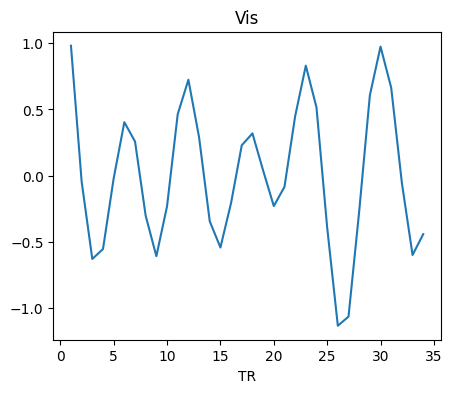

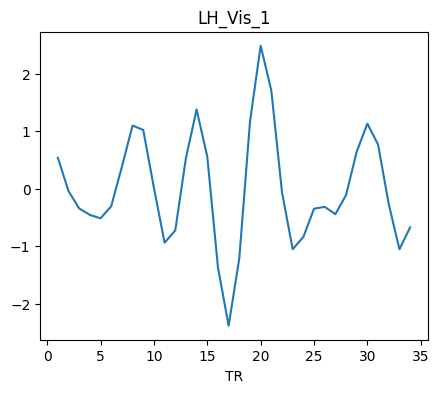

In [8]:
if "AAL" in parcel_approach:
    extractor.visualize_bold(subj_id="01", run="001", region="Precentral", figsize=(5, 4))

    extractor.visualize_bold(subj_id="01", run="001", roi_indx=0, figsize=(5, 4))
else:
    extractor.visualize_bold(subj_id="01", run="001", region="Vis", figsize=(5, 4))

    extractor.visualize_bold(subj_id="01", run="001", roi_indx="LH_Vis_1", figsize=(5, 4))

 <font size="6">Saving Timeseries as Pickle</font>
 
 <font size="3">`self.get_bold` produces a nested dictionary structure containing the subject id, run id, and the associated timeseries data. This nested dictionary is stored in the `self.subject_timeseries` attribute and can be saved as a pickle file using `self.timeseries_to_pickle`.</font>

In [9]:
output_dir = "neurocaps_demo"
extractor.timeseries_to_pickle(
    output_dir=output_dir, filename="sample_for_neurocaps_demo_timeseries.pkl"
)

 <font size="6">Co-Activation Patterns (CAPs) With No Groups</font>
 
 <font size="3">Initializing the `CAP` class and using the saved pickle file as input for `self.get_caps`.  When group is `None`, which is the default value of this parameter, then the default group name is "All Subjects".</font>

[06/13/25 05:45:34] INFO     2025-06-13 05:45:34,981 neurocaps.analysis.cap [INFO] No groups specified.  ]8;id=534208;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap.py\cap.py]8;;\:]8;id=183455;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap.py#522\522]8;;\
                             Using default group 'All Subjects' containing all subject IDs from                    
                             `subject_timeseries`. The `self.groups` dictionary will remain fixed unless           
                             the `CAP` class is re-initialized or `self.clear_groups()` is used.                   

[06/13/25 05:45:35] INFO     2025-06-13 05:45:35,131 neurocaps.analysis.cap [INFO] [GROUP: All Subjects  ]8;id=796162;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap.py\cap.py]8;;\:]8;id=387048;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap.py#694\694]8;;\
                             | METHOD: davies_bouldin] Optimal cluster size is 3.                                  

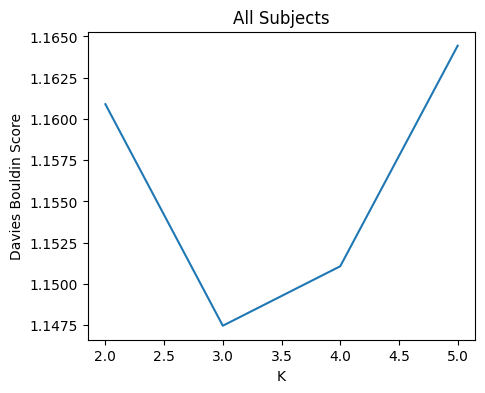

In [10]:
# `parcel_approach` is only required for certain visualization functions and can be set later
# cap_analysis = CAP(parcel_approach = {"Schaefer": {"n_rois": 100}})

cap_analysis = CAP(extractor.parcel_approach, groups=None)

cap_analysis.get_caps(
    subject_timeseries=os.path.join(output_dir, "sample_for_neurocaps_demo_timeseries.pkl"),
    n_clusters=range(2, 6),  # Test k=2 to k=5
    standardize=True,
    cluster_selection_method="davies_bouldin",
    show_figs=True,
    figsize=(5, 4),
)

# The concatenated data can be safely deleted since only the kmeans models and any standardization parameters are
# used for computing temporal metrics.

del cap_analysis.concatenated_timeseries

In [11]:
# Print metadata
print(cap_analysis)

Current Object State:
Parcellation Approach                                       : Schaefer
Groups                                                      : All Subjects
Number of Clusters                                          : [2, 3, 4, 5]
Cluster Selection Method                                    : davies_bouldin
Optimal Number of Clusters (if Range of Clusters Provided)  : {'All Subjects': 3}
CPU Cores Used for Clustering (Multiprocessing)             : None
User-Specified Runs IDs Used for Clustering                 : None
Concatenated Timeseries Bytes                               : 0 bytes
Standardized Concatenated Timeseries                        : True
Co-Activation Patterns (CAPs)                               : {'All Subjects': 3}
Variance Explained by Clustering                            : {'All Subjects': np.float32(0.5325075)}


<font size="6">Return CAP Labels for Each Subject</font>

In [12]:
cap_labels_dict = cap_analysis.return_cap_labels(
    subject_timeseries=os.path.join(output_dir, "sample_for_neurocaps_demo_timeseries.pkl")
    )

cap_labels_dict

{'01': {'run-001': array([0, 2, 2, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 1, 1, 2, 2, 0, 0, 0, 0,
         2, 2, 2, 1, 1, 1, 0, 0, 0, 2, 1, 1], dtype=int32)}}

 <font size="6">Calculating CAP Metrics With No Groups</font>

 <font size="3">Getting CAP metrics using the `self.calculate_metrics` method. Available metrics includes "counts", "temporal_fraction", "persistence", "transition_frequency", and "transition_probability".</font>

In [13]:
# Get metric for the single subject in this `subject_timeseries` pickle file
cap_analysis.calculate_metrics(
    subject_timeseries=os.path.join(output_dir, "sample_for_neurocaps_demo_timeseries.pkl"),
    metrics="persistence",
)["persistence"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3
0,01,All Subjects,run-001,3.0,2.0,2.2


 <font size="6">Co-Activation Patterns (CAPs) With Groups</font>
 
 <font size="3">Performing CAP analysis for two groups using the `groups` parameter when initializing the `CAP` class. Also finding the optimal cluster size for each group by using the elbow method. Additional options for `cluster_selection_method` includes the "silhouette", "davies_bouldin", and "variance_ratio". Additionally, visualizations from any method that produces them can be saved using `output_dir`, all methods have docstrings explaining their purpose, available parameters, kwargs, and properties (in the case of classes). For demonstration purposes, a simulated `subject_timeseries` is created. Below, clustering is based on only run-1 and run-2 timeseries data from `subject_timeseries`.</font>

                    WARNING  2025-06-13 05:45:35,367                                   ]8;id=171097;file://C:\Users\donis\Github\neurocaps\neurocaps\_utils\check_parcel_approach.py\check_parcel_approach.py]8;;\:]8;id=516520;file://C:\Users\donis\Github\neurocaps\neurocaps\_utils\check_parcel_approach.py#176\176]8;;\
                             neurocaps._utils.check_parcel_approach [WARNING]                                      
                             'yeo_networks' not specified in `parcel_approach`.                                    
                             Defaulting to 7 networks.                                                             

                    WARNING  2025-06-13 05:45:35,367                                   ]8;id=555001;file://C:\Users\donis\Github\neurocaps\neurocaps\_utils\check_parcel_approach.py\check_parcel_approach.py]8;;\:]8;id=95801;file://C:\Users\donis\Github\neurocaps\neurocaps\_utils\check_parcel_approach.py#180\180]8;;\
                             neurocaps._utils.check_parcel_approach [WARNING]                                      
                             'resolution_mm' not specified in `parcel_approach`.                                   
                             Defaulting to 1mm.                                                                    

Concatenating Timeseries Data Per Group:   0%|          | 0/2 [00:00<?, ?it/s]

Clustering [GROUP: High ADHD]:   0%|          | 0/23 [00:00<?, ?it/s]

[06/13/25 05:45:41] INFO     2025-06-13 05:45:41,077 neurocaps.analysis.cap [INFO] [GROUP: High ADHD |   ]8;id=612573;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap.py\cap.py]8;;\:]8;id=319810;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap.py#694\694]8;;\
                             METHOD: silhouette] Optimal cluster size is 2.                                        

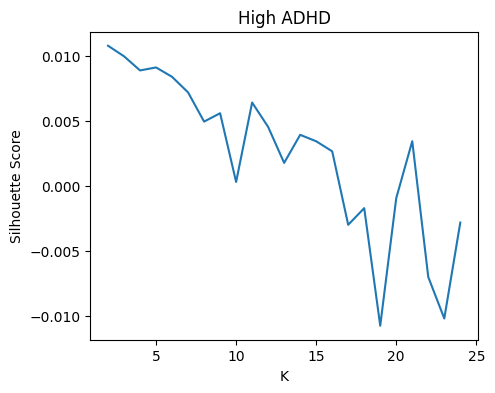

Clustering [GROUP: Low ADHD]:   0%|          | 0/23 [00:00<?, ?it/s]

                    INFO     2025-06-13 05:45:41,459 neurocaps.analysis.cap [INFO] [GROUP: Low ADHD |    ]8;id=374139;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap.py\cap.py]8;;\:]8;id=397564;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap.py#694\694]8;;\
                             METHOD: silhouette] Optimal cluster size is 2.                                        

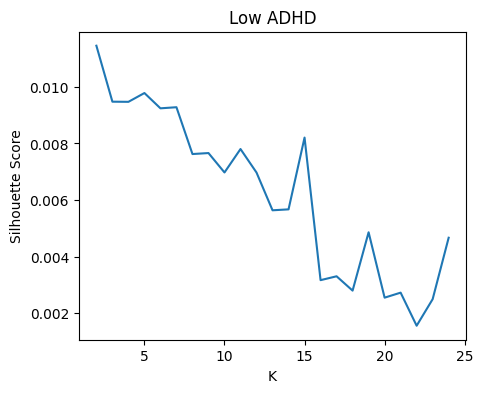

In [14]:
# Simulating a nested dictionary structure containing group data
sub_ids = [f"0{x}" if x < 10 else x for x in range(1, 11)]
subject_timeseries = {
    str(x): {f"run-{y}": np.random.rand(50, ncol) for y in range(1, 4)} for x in sub_ids
}

# Initializing CAP class and performing the elbow method
cap_analysis = CAP(
    groups={
        "High ADHD": ["01", "02", "03", "05"],
        "Low ADHD": ["04", "06", "07", "08", "09", "10"],
    }
)

# Setting parcel approach instead of assigning it during initialization of the CAP class
cap_analysis.parcel_approach = parcel_approach

cap_analysis.get_caps(
    subject_timeseries=subject_timeseries,
    runs=[1, 2],
    n_clusters=range(2, 25),
    cluster_selection_method="silhouette",
    n_cores=2,  # Used when `n_clusters` is a list, to run multiple kmeans simultaneously
    show_figs=True,
    figsize=(5, 4),
    progress_bar=True,
)

In [15]:
# Print metadata
print(cap_analysis)

Current Object State:
Parcellation Approach                                       : Schaefer
Groups                                                      : High ADHD, Low ADHD
Number of Clusters                                          : [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
Cluster Selection Method                                    : silhouette
Optimal Number of Clusters (if Range of Clusters Provided)  : {'High ADHD': 2, 'Low ADHD': 2}
CPU Cores Used for Clustering (Multiprocessing)             : 2
User-Specified Runs IDs Used for Clustering                 : [1, 2]
Concatenated Timeseries Bytes                               : 800184 bytes
Standardized Concatenated Timeseries                        : True
Co-Activation Patterns (CAPs)                               : {'High ADHD': 2, 'Low ADHD': 2}
Variance Explained by Clustering                            : {'High ADHD': np.float64(0.013063084108162593), 'Low ADHD': np.float64(0.0131781

<font size="6">Calculating CAPs Metrics With Groups</font>

 <font size="3">Note, all groups are in the same dataframe for simplicity purposes (except for "transition_probability" where each group has separate dataframes) but use their own kmeans models to calculate each metric. Consequently, "CAP-1" and "CAP-2" are different for each group. In cases where the optimal cluster size for each group differs, values assigned as NaN is just indicates that a group does not have a particular CAP. This done to differentiate it from 0, which indicates a particular CAP did not appear in a subject.
 
 Furthermore, a `run` parameter is offered in `calculate_metrics`. Despite clustering only being done on the first two runs, any run combination can be selected.</font>

In [16]:
cap_analysis.calculate_metrics(subject_timeseries=subject_timeseries, runs=[1, 2])[
    "temporal_fraction"
]

,Subject_ID,Group,Run,CAP-1,CAP-2
0,01,High ADHD,run-1,0.54,0.46
1,01,High ADHD,run-2,0.48,0.52
2,02,High ADHD,run-1,0.40,0.60
3,02,High ADHD,run-2,0.40,0.60
4,03,High ADHD,run-1,0.50,0.50
5,03,High ADHD,run-2,0.44,0.56
6,05,High ADHD,run-1,0.40,0.60
7,05,High ADHD,run-2,0.48,0.52
8,04,Low ADHD,run-1,0.44,0.56
9,04,Low ADHD,run-2,0.52,0.48


<font size="3">The first two runs are selected and treated as continuous, the reduce the number of downstream statistical analyses.</font>

In [17]:
cap_analysis.calculate_metrics(
    subject_timeseries=subject_timeseries, runs=[1, 2], continuous_runs=True
)["counts"]

,Subject_ID,Group,Run,CAP-1,CAP-2
0,01,High ADHD,run-continuous,24,23
1,02,High ADHD,run-continuous,25,26
2,03,High ADHD,run-continuous,28,27
3,05,High ADHD,run-continuous,28,29
4,04,Low ADHD,run-continuous,24,24
5,06,Low ADHD,run-continuous,22,23
6,07,Low ADHD,run-continuous,27,27
7,08,Low ADHD,run-continuous,27,28
8,09,Low ADHD,run-continuous,26,27
9,10,Low ADHD,run-continuous,30,30


 <font size="6">Calculating CAP Metrics and Treating Separate Runs as Continuous Runs </font>

In [18]:
metrics = cap_analysis.calculate_metrics(
    subject_timeseries=subject_timeseries,
    metrics="transition_probability",
    runs=[1],
)

metrics["transition_probability"]["High ADHD"]

,Subject_ID,Group,Run,1.1,1.2,2.1,2.2
0,01,High ADHD,run-1,0.555556,0.444444,0.500000,0.500000
1,02,High ADHD,run-1,0.315789,0.684211,0.466667,0.533333
2,03,High ADHD,run-1,0.416667,0.583333,0.560000,0.440000
3,05,High ADHD,run-1,0.368421,0.631579,0.433333,0.566667


  <font size="6">Transition Probability Matrix</font>
  
 <font size="3">`transition_matrix` can be used to generate and visualize the averaged transition probabilities for each group. </font>

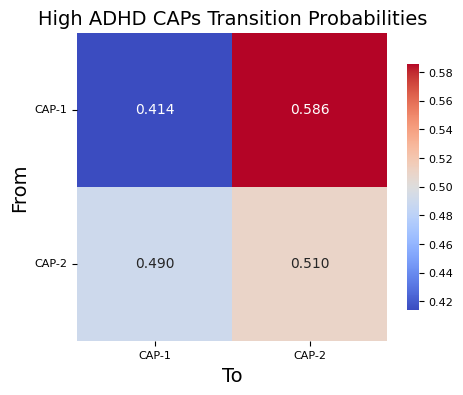

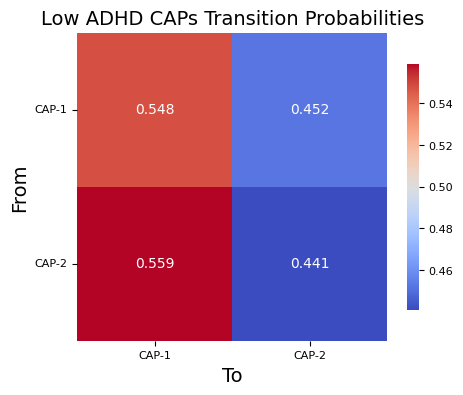

,CAP-1,CAP-2
From/To,,
CAP-1,0.547716,0.452284
CAP-2,0.559071,0.440929


In [19]:
from neurocaps.analysis import transition_matrix

trans_df = transition_matrix(
    trans_dict=metrics["transition_probability"],
    annot=True,
    fmt=".3f",
    return_df=True,
    figsize=(5, 4),
    show_figs=True,
)

trans_df["Low ADHD"]

<font size="6">Plotting CAPs as Outer Products and Heatmaps </font>

 <font size="3">Visualizing CAPs as outer product heatmap at the regional/network level using `self.caps2plot` method.</font>

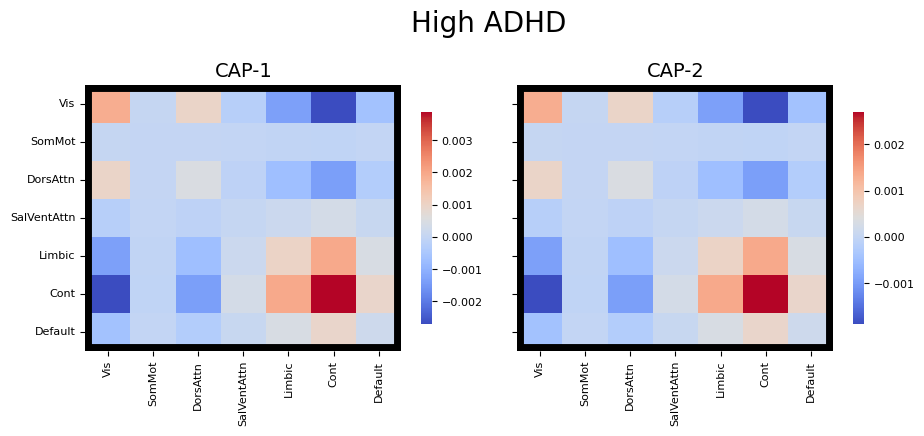

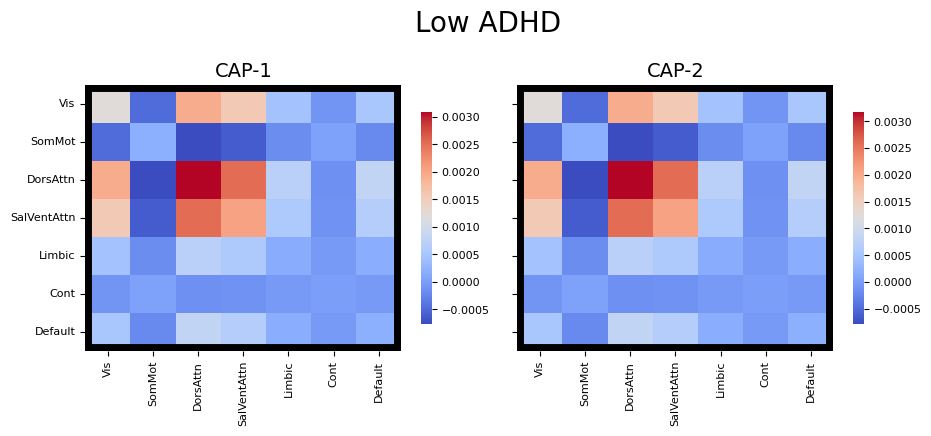

In [20]:
cap_analysis.caps2plot(
    subplots=True, xlabel_rotation=90, sharey=True, borderwidths=10, figsize=(9, 4)
)

 <font size="3">Visualizing CAPs as outer product heatmap at the node level using `self.caps2plot` method.</font>

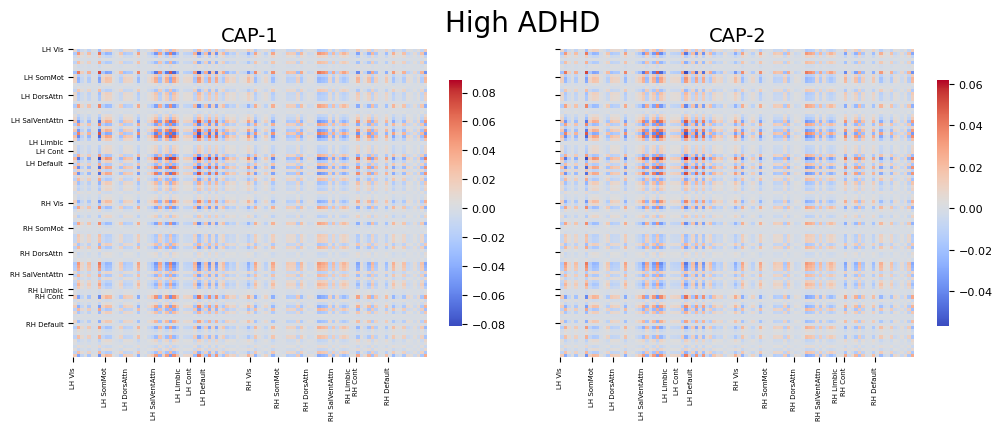

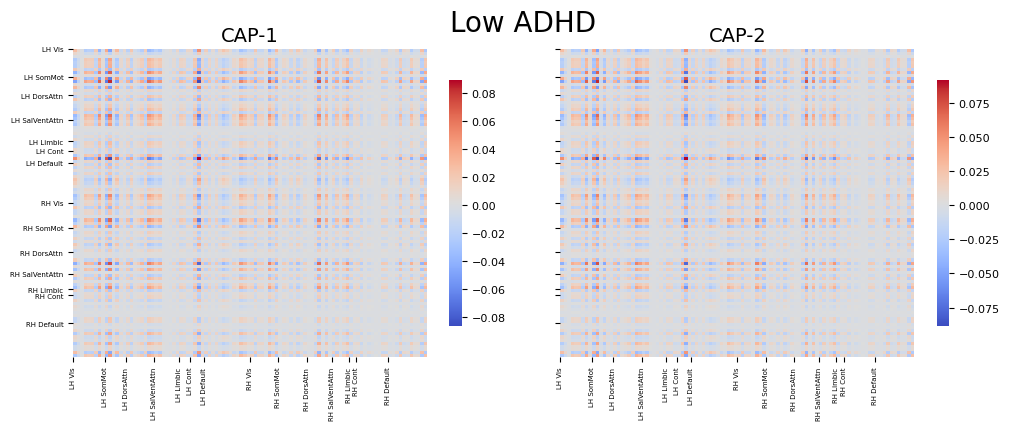

In [21]:
cap_analysis.caps2plot(
    yticklabels_size=5,
    wspace=0.1,
    subplots=True,
    visual_scope="nodes",
    xlabel_rotation=90,
    xticklabels_size=5,
    hspace=0.6,
    tight_layout=False,
    figsize=(12, 4),
)

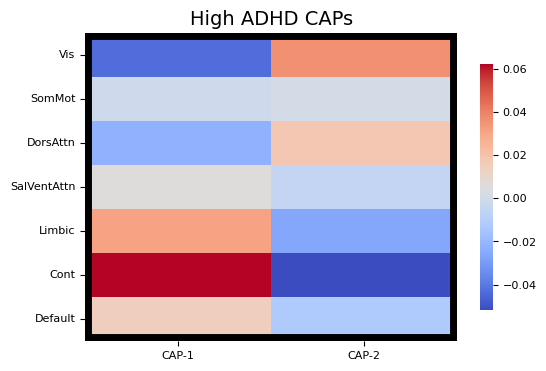

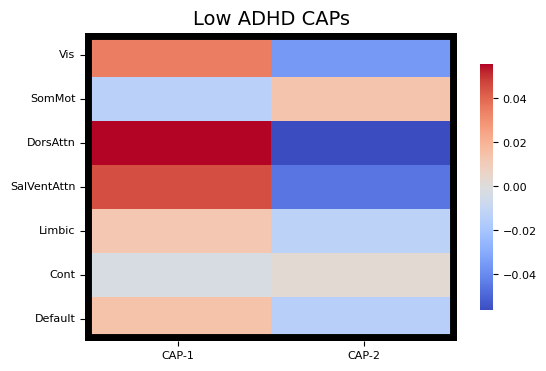

In [22]:
cap_analysis.caps2plot(
    subplots=True,
    visual_scope="regions",
    plot_options="heatmap",
    borderwidths=10,
    figsize=(6, 4),
)

 <font size="6">Merging Different Timeseries Across Sessions or Tasks </font>

 <font size="3">Using `merge_dicts` to merge common subjects across different subject timeseries dictionaries. This is to allow CAPs to be estimated on the merged dictionary (for similar CAPs across tasks or sessions) and for metrics to be calculated for each of the individual dictionaries. For instance, `subject_timeseries_1` may be the extracted timeseries from session 1 and `subject_timeseries_2` are the extracted timeseries for session 2. When merged, only subjects that have at least a single run across sessions will be returned in the merged dictionary. When `return_reduced_dicts` is True, only the subjects in the merged dictionary will be returned for the reduced dictionaries. In this example "dict_0" is the reduced form of `subject_timeseries_1` and "dict_1" is the reduced form of `subject_timeseries_2`. So, "merged" can be used as the input to estimate common CAPs across sessions for `get_caps` and "dict_0" and "dict_1" can be used as inputs for `self.calculate_metrics` to obtain the metrics for the CAPs for each session.</font>

In [23]:
# Simulating two separate `subject_timeseries`
sub_ids = [f"0{x}" if x < 10 else x for x in range(1, 11)]
subject_timeseries_1 = {
    str(x): {f"run-{y}": np.random.rand(100, 400) for y in range(1, 4)} for x in sub_ids
}
subject_timeseries_2 = {
    str(x): {f"run-{y}": np.random.rand(100, 400) for y in range(1, 4)} for x in sub_ids[:8]
}

# Returns merged dictionary as well as the reduced subject dictionaries containing only the subjects present in the merged
all_dicts = merge_dicts(
    subject_timeseries_list=[subject_timeseries_1, subject_timeseries_2],
    return_merged_dict=True,
    return_reduced_dicts=True,
)

print(all_dicts["dict_0"].keys())
print(all_dicts["dict_1"].keys())
print(all_dicts["merged"].keys())

dict_keys(['01', '02', '03', '04', '05', '06', '07', '08'])
dict_keys(['01', '02', '03', '04', '05', '06', '07', '08'])
dict_keys(['01', '02', '03', '04', '05', '06', '07', '08'])


 <font size="6">Identifying CAPs in Merged Timeseries </font>

 <font size="3">Generating examples not using the `group` parameter. Note, some additional plotting and non-plotting methods are shown below, all methods in the `CAP` class works regardless if `group` is None or defined since plots are generated for each group. The merged timeseries in `all_dicts` which was generated in the previous cell will be used as input here.</font>

In [24]:
cap_analysis = CAP(
    parcel_approach={"Schaefer": {"n_rois": 400, "resolution_mm": 1, "yeo_networks": 7}}
)

cap_analysis.get_caps(subject_timeseries=all_dicts["merged"], n_clusters=3)

[06/13/25 05:45:44] INFO     2025-06-13 05:45:44,537 neurocaps.analysis.cap [INFO] No groups specified.  ]8;id=86729;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap.py\cap.py]8;;\:]8;id=210878;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap.py#522\522]8;;\
                             Using default group 'All Subjects' containing all subject IDs from                    
                             `subject_timeseries`. The `self.groups` dictionary will remain fixed unless           
                             the `CAP` class is re-initialized or `self.clear_groups()` is used.                   

 <font size="6">Calculating CAP Metrics on Subsets of Merged Timeseries </font>

In [25]:
output = cap_analysis.calculate_metrics(
    subject_timeseries=all_dicts["dict_0"], return_df=True, runs=[1, 2]
)

output["temporal_fraction"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3
0,01,All Subjects,run-1,0.38,0.34,0.28
1,01,All Subjects,run-2,0.32,0.38,0.30
2,02,All Subjects,run-1,0.26,0.40,0.34
3,02,All Subjects,run-2,0.34,0.37,0.29
4,03,All Subjects,run-1,0.33,0.36,0.31
5,03,All Subjects,run-2,0.37,0.36,0.27
6,04,All Subjects,run-1,0.35,0.37,0.28
7,04,All Subjects,run-2,0.26,0.37,0.37
8,05,All Subjects,run-1,0.26,0.37,0.37
9,05,All Subjects,run-2,0.32,0.37,0.31


In [26]:
output = cap_analysis.calculate_metrics(
    subject_timeseries=all_dicts["dict_1"],
    return_df=True,
    runs=[1, 2],
    continuous_runs=True,
)

output["persistence"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3
0,01,All Subjects,run-continuous,1.380952,1.770833,1.390244
1,02,All Subjects,run-continuous,1.568182,1.477273,1.534884
2,03,All Subjects,run-continuous,1.323529,1.681818,1.500000
3,04,All Subjects,run-continuous,1.674419,1.477273,1.536585
4,05,All Subjects,run-continuous,1.444444,1.708333,1.650000
5,06,All Subjects,run-continuous,1.341463,1.693878,1.319149
6,07,All Subjects,run-continuous,1.466667,1.568182,1.477273
7,08,All Subjects,run-continuous,1.444444,1.700000,1.488889


In [27]:
output = cap_analysis.calculate_metrics(
    subject_timeseries=all_dicts["dict_1"], return_df=True, runs=[1, 2]
)

output["transition_frequency"]

,Subject_ID,Group,Run,Transition_Frequency
0,01,All Subjects,run-1,68
1,01,All Subjects,run-2,61
2,02,All Subjects,run-1,65
3,02,All Subjects,run-2,65
4,03,All Subjects,run-1,65
5,03,All Subjects,run-2,66
6,04,All Subjects,run-1,70
7,04,All Subjects,run-2,56
8,05,All Subjects,run-1,57
9,05,All Subjects,run-2,65


<font size="6">CAPs Correlation Matrix </font>

 <font size="3">`self.caps2corr` can be used to obtain the Pearson or Spearman correlation between CAPs and to obtain a dataframe of the uncorrected p-values.</font>

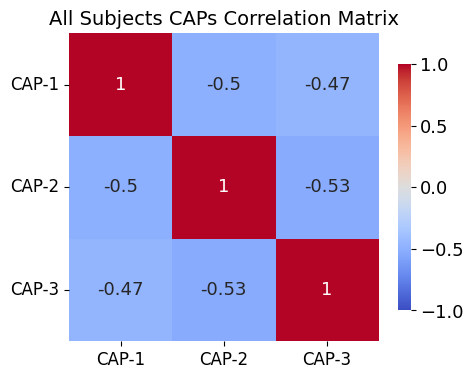

,CAP-1,CAP-2,CAP-3
CAP-1,1 (0)***,-0.5 (3.5e-27)***,-0.47 (5.2e-23)***
CAP-2,-0.5 (3.5e-27)***,1 (0)***,-0.53 (3.6e-30)***
CAP-3,-0.47 (5.2e-23)***,-0.53 (3.6e-30)***,1 (0)***


In [28]:
corr_df = cap_analysis.caps2corr(
    method="pearson",
    annot=True,
    figsize=(5, 4),
    xticklabels_size=12,
    yticklabels_size=12,
    return_df=True,
    vmin=-1,
    vmax=1,
    annot_kws={"size": 13},
    cbarlabels_size=13,
)

corr_df["All Subjects"]

 <font size="6">CAPs Surface Plots </font> 
 
 <font size="3">Visualizing CAPs as surface plots using `self.caps2surf` method.</font>

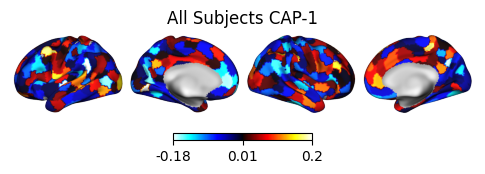

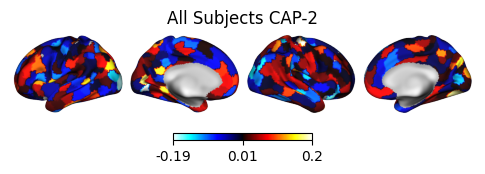

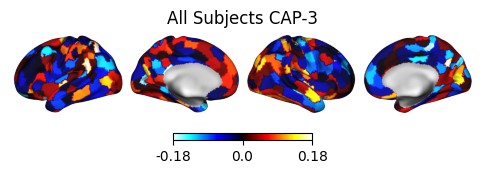

Generating Surface Plots [GROUP: All Subjects]:   0%|          | 0/3 [00:00<?, ?it/s]

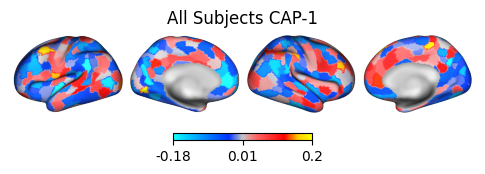

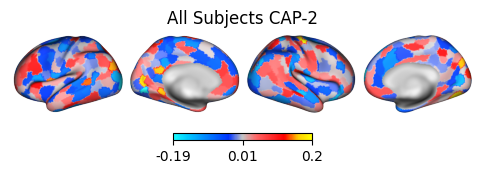

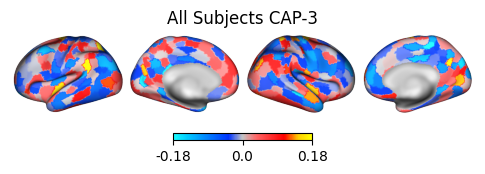

In [29]:
from matplotlib.colors import LinearSegmentedColormap

colors = [
    "#1bfffe",
    "#00ccff",
    "#0099ff",
    "#0066ff",
    "#0033ff",
    "#c4c4c4",
    "#ff6666",
    "#ff3333",
    "#FF0000",
    "#ffcc00",
    "#FFFF00",
]

cap_analysis.caps2surf(cmap="cold_hot", layout="row", size=(500, 100))

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cold_hot", colors, N=256)

cap_analysis.caps2surf(
    cmap=custom_cmap, size=(500, 100), layout="row", surface="veryinflated", progress_bar=True
)

 <font size="6">CAPs to NifTIs </font>

 <font size="3">CAPs can also be projected onto the parcellation and saved as NifTI files. These same files can also be saved when using `self.caps2surf`. Additionally, this function also has the `knn_dict` parameter.</font>

In [30]:
cap_analysis.caps2niftis(
    output_dir=output_dir, suffix_filename="for_neurocaps_demo", progress_bar=True
)

Generating Statistical Maps [GROUP: All Subjects]:   0%|          | 0/3 [00:00<?, ?it/s]

<font size="6">CAPs to Radar Plots </font>

 <font size="3">Radar plots showing the cosine similarity between each network and the positive ("High Amplitude") and negative ("Low Amplitude") activations in each CAP. Since this function assumes that the matrix subjected to kmeans clustering was standardized, "High Amplitude" represents values above the mean (0) and "Low Amplitude" represents values below the mean (0). During calculation of the "Low Amplitude" cosine similarity, the inverse is computed to turn this similarity positive for visualization purposes.</font>

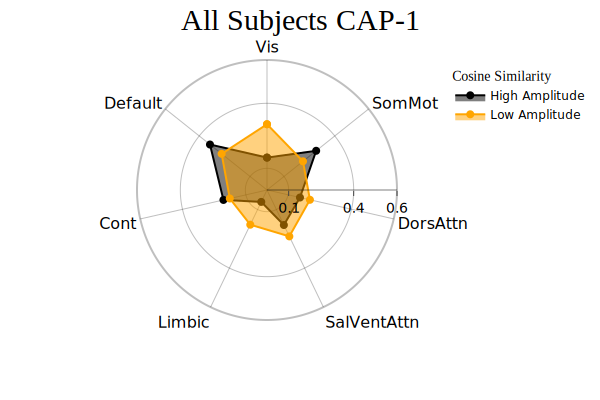

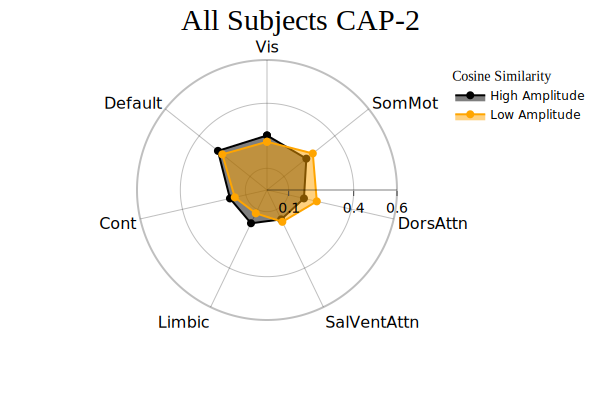

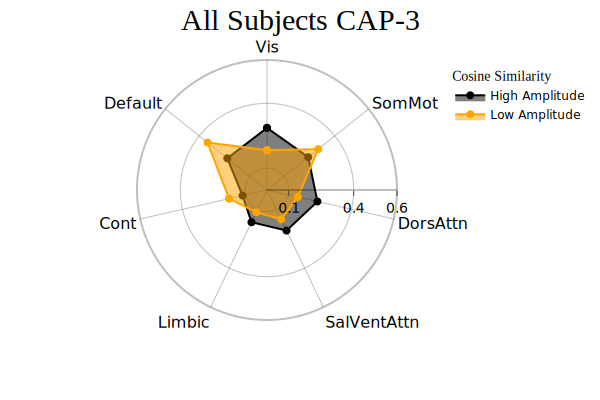

In [31]:
radialaxis = {
    "showline": True,
    "linewidth": 2,
    "linecolor": "rgba(0, 0, 0, 0.25)",
    "gridcolor": "rgba(0, 0, 0, 0.25)",
    "ticks": "outside",
    "tickfont": {"size": 14, "color": "black"},
    "range": [0, 0.6],
    "tickvals": [0.1, "", "", 0.4, "", "", 0.6],
}

legend = {
    "yanchor": "top",
    "y": 0.99,
    "x": 0.99,
    "title_font_family": "Times New Roman",
    "font": {"size": 12, "color": "black"},
}

colors = {"High Amplitude": "black", "Low Amplitude": "orange"}

cap_analysis.caps2radar(
    radialaxis=radialaxis,
    height=400,
    width=600,
    color_discrete_map=colors,
    legend=legend,
)

 <font size="3">The cosine similarities are stored in the `self.cosine_similarity` property.</font>

In [32]:
import pandas as pd

df = pd.DataFrame(cap_analysis.cosine_similarity["All Subjects"]["CAP-1"])

df["Regions"] = cap_analysis.cosine_similarity["All Subjects"]["Regions"]

print(df)

   High Amplitude  Low Amplitude      Regions
0        0.149581       0.303521          Vis
1        0.290217       0.212401       SomMot
2        0.156092       0.203182     DorsAttn
3        0.179380       0.237666  SalVentAttn
4        0.061014       0.177772       Limbic
5        0.206134       0.176090         Cont
6        0.336574       0.267908      Default


  <font size="6">Using Custom Parcellations </font>

 <font size="3">The NeuroCAPs package uses Nilearn to obtain the "maps" and "nodes" for the Schaefer and AAL atlases, then uses some Python code to create a list of "regions" using the "nodes" list. NeuroCAPs can also accept additional parcellations (as long as they are lateralized since the current iteration of the codebase assumes an "lh" and "rh" key for each region but this may be changed in a future update. Below is an example using the HCPex atlas from [wayalan Github](https://github.com/wayalan/HCPex/) for the `CAP` class.</font>

In [33]:
import subprocess

# Fetching atlas NiFTI image and labels from Github
if sys.platform != "win32":
    cmd = [
        [
            "wget",
            "-q",
            "-P",
            output_dir,
            "https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex_LookUpTable.txt",
        ],
        [
            "wget",
            "-q",
            "-P",
            output_dir,
            "https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex.nii.gz",
        ],
    ]
else:
    cmd = [
        [
            "curl",
            "-L",
            "-o",
            f"{output_dir}\\HCPex_LookUpTable.txt",
            "https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex_LookUpTable.txt",
        ],
        [
            "curl",
            "-L",
            "-o",
            f"{output_dir}\\HCPex.nii.gz",
            "https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex.nii.gz",
        ],
    ]

for command in cmd:
    subprocess.run(command, check=True)

# Creating custom parcel approach dictionary and extracting timeseries
parcel_approach = {"Custom": {}}

# Setting the "maps", which is needed for `TimeseriesExtractore.get_bold()` and `CAP.caps2niftis` and `CAP.cap2surf`
parcel_approach["Custom"]["maps"] = os.path.join(output_dir, "HCPex.nii.gz")

# Setting the "nodes", which is needed for "TimeseriesExtractor.visualize_bold"; Getting nodes
# that don't correspond to background label
parcel_approach["Custom"]["nodes"] = pd.read_csv(
    os.path.join(output_dir, "HCPex_LookUpTable.txt"),
    sep=None,
    engine="python",
)["Label"].values[1:]

# Needed for many plotting methods; Setting the region names and their corresponding indices in
# the nodes list, in this case it is just the label id - 1
parcel_approach["Custom"]["regions"] = {
    "Primary Visual": {"lh": [0], "rh": [180]},
    "Early Visual": {"lh": [1, 2, 3], "rh": [181, 182, 183]},
    "Dorsal Stream Visual": {"lh": range(4, 10), "rh": range(184, 190)},
    "Ventral Stream Visual": {"lh": range(10, 17), "rh": range(190, 197)},
    "MT+ Complex": {"lh": range(17, 26), "rh": range(197, 206)},
    "SomaSens Motor": {"lh": range(26, 31), "rh": range(206, 211)},
    "ParaCentral MidCing": {"lh": range(31, 40), "rh": range(211, 220)},
    "Premotor": {"lh": range(40, 47), "rh": range(220, 227)},
    "Posterior Opercular": {"lh": range(47, 52), "rh": range(227, 232)},
    "Early Auditory": {"lh": range(52, 59), "rh": range(232, 239)},
    "Auditory Association": {"lh": range(59, 67), "rh": range(239, 247)},
    "Insula FrontalOperc": {"lh": range(67, 79), "rh": range(247, 259)},
    "Medial Temporal": {"lh": range(79, 87), "rh": range(259, 267)},
    "Lateral Temporal": {"lh": range(87, 95), "rh": range(267, 275)},
    "TPO": {"lh": range(95, 100), "rh": range(275, 280)},
    "Superior Parietal": {"lh": range(100, 110), "rh": range(280, 290)},
    "Inferior Parietal": {"lh": range(110, 120), "rh": range(290, 300)},
    "Posterior Cingulate": {"lh": range(120, 133), "rh": range(300, 313)},
    "AntCing MedPFC": {"lh": range(133, 149), "rh": range(313, 329)},
    "OrbPolaFrontal": {"lh": range(149, 158), "rh": range(329, 338)},
    "Inferior Frontal": {"lh": range(158, 167), "rh": range(338, 347)},
    "Dorsolateral Prefrontal": {"lh": range(167, 180), "rh": range(347, 360)},
    "Subcortical Regions": {"lh": range(360, 393), "rh": range(393, 426)},
}

# Saving the dictionary as a pickle file
with open(os.path.join(output_dir, "HCPex_dict.pkl"), "wb") as f:
    joblib.dump(parcel_approach, f)

As of version >= 0.30.0, regions non-lateralized regions are supported.

In [34]:
# Non-lateralized regions
regions_non_lateralized = {
    "Primary Visual": [0, 180],
    "Early Visual": [1, 2, 3, 181, 182, 183],
    "Dorsal Stream Visual": [*range(4, 10), *range(184, 190)],
    "Ventral Stream Visual": [*range(10, 17), *range(190, 197)],
    "MT+ Complex": [*range(17, 26), *range(197, 206)],
    "SomaSens Motor": [*range(26, 31), *range(206, 211)],
    "ParaCentral MidCing": [*range(31, 40), *range(211, 220)],
    "Premotor": [*range(40, 47), *range(220, 227)],
    "Posterior Opercular": [*range(47, 52), *range(227, 232)],
    "Early Auditory": [*range(52, 59), *range(232, 239)],
    "Auditory Association": [*range(59, 67), *range(239, 247)],
    "Insula FrontalOperc": [*range(67, 79), *range(247, 259)],
    "Medial Temporal": [*range(79, 87), *range(259, 267)],
    "Lateral Temporal": [*range(87, 95), *range(267, 275)],
    "TPO": [*range(95, 100), *range(275, 280)],
    "Superior Parietal": [*range(100, 110), *range(280, 290)],
    "Inferior Parietal": [*range(110, 120), *range(290, 300)],
    "Posterior Cingulate": [*range(120, 133), *range(300, 313)],
    "AntCing MedPFC": [*range(133, 149), *range(313, 329)],
    "OrbPolaFrontal": [*range(149, 158), *range(329, 338)],
    "Inferior Frontal": [*range(158, 167), *range(338, 347)],
    "Dorsolateral Prefrontal": [*range(167, 180), *range(347, 360)],
    "Subcortical Regions": [*range(360, 393), *range(393, 426)],
}

# Mix of lateralized and non-lateralized regions
regions_mixed = {
    # Non-Lateralized Regions
    "Primary Visual": [*[0], *[180]],
    "Early Visual": [*[1, 2, 3], *[181, 182, 183]],
    "Dorsal Stream Visual": [*range(4, 10), *range(184, 190)],
    "Ventral Stream Visual": [*range(10, 17), *range(190, 197)],
    "ParaCentral MidCing": [*range(31, 40), *range(211, 220)],
    "Posterior Cingulate": [*range(120, 133), *range(300, 313)],
    "AntCing MedPFC": [*range(133, 149), *range(313, 329)],
    "Subcortical Regions": [*range(360, 393), *range(393, 426)],

    # Lateralized Regions
    "MT+ Complex": {"lh": range(17, 26), "rh": range(197, 206)},
    "SomaSens Motor": {"lh": range(26, 31), "rh": range(206, 211)},
    "Premotor": {"lh": range(40, 47), "rh": range(220, 227)},
    "Posterior Opercular": {"lh": range(47, 52), "rh": range(227, 232)},
    "Early Auditory": {"lh": range(52, 59), "rh": range(232, 239)},
    "Auditory Association": {"lh": range(59, 67), "rh": range(239, 247)},
    "Insula FrontalOperc": {"lh": range(67, 79), "rh": range(247, 259)},
    "Medial Temporal": {"lh": range(79, 87), "rh": range(259, 267)},
    "Lateral Temporal": {"lh": range(87, 95), "rh": range(267, 275)},
    "TPO": {"lh": range(95, 100), "rh": range(275, 280)},
    "Superior Parietal": {"lh": range(100, 110), "rh": range(280, 290)},
    "Inferior Parietal": {"lh": range(110, 120), "rh": range(290, 300)},
    "OrbPolaFrontal": {"lh": range(149, 158), "rh": range(329, 338)},
    "Inferior Frontal": {"lh": range(158, 167), "rh": range(338, 347)},
    "Dorsolateral Prefrontal": {"lh": range(167, 180), "rh": range(347, 360)},
}

<font size="3">For "Custom" parcel approaches, all visualization methods can be used.

In [35]:
# Creating new subject timeseries that has 426 columns
sub_ids = [f"0{x}" if x < 10 else x for x in range(1, 11)]
subject_timeseries = {
    str(x): {f"run-{y}": np.random.rand(50, 426) for y in range(1, 4)} for x in sub_ids
}

cap_analysis = CAP(parcel_approach=os.path.join(output_dir, "HCPex_dict.pkl"))

cap_analysis.get_caps(
    subject_timeseries=subject_timeseries,
    cluster_selection_method="variance_ratio",
    n_clusters=range(2, 11),
)

# The `parcel_approach`` can be set using the dictionary format when initializing the `CAP` class or using the `parcel_approach` property as a setter
# cap_analysis.parcel_approach = parcel_approach
# cap_analysis.parcel_approach = os.path.join(output_dir, "neurocaps_demo", "HCPex_dict.pkl")

[06/13/25 05:47:07] INFO     2025-06-13 05:47:07,560 neurocaps.analysis.cap [INFO] No groups specified.  ]8;id=115852;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap.py\cap.py]8;;\:]8;id=802420;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap.py#522\522]8;;\
                             Using default group 'All Subjects' containing all subject IDs from                    
                             `subject_timeseries`. The `self.groups` dictionary will remain fixed unless           
                             the `CAP` class is re-initialized or `self.clear_groups()` is used.                   

                    INFO     2025-06-13 05:47:07,907 neurocaps.analysis.cap [INFO] [GROUP: All Subjects  ]8;id=215182;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap.py\cap.py]8;;\:]8;id=730392;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap.py#694\694]8;;\
                             | METHOD: variance_ratio] Optimal cluster size is 2.                                  

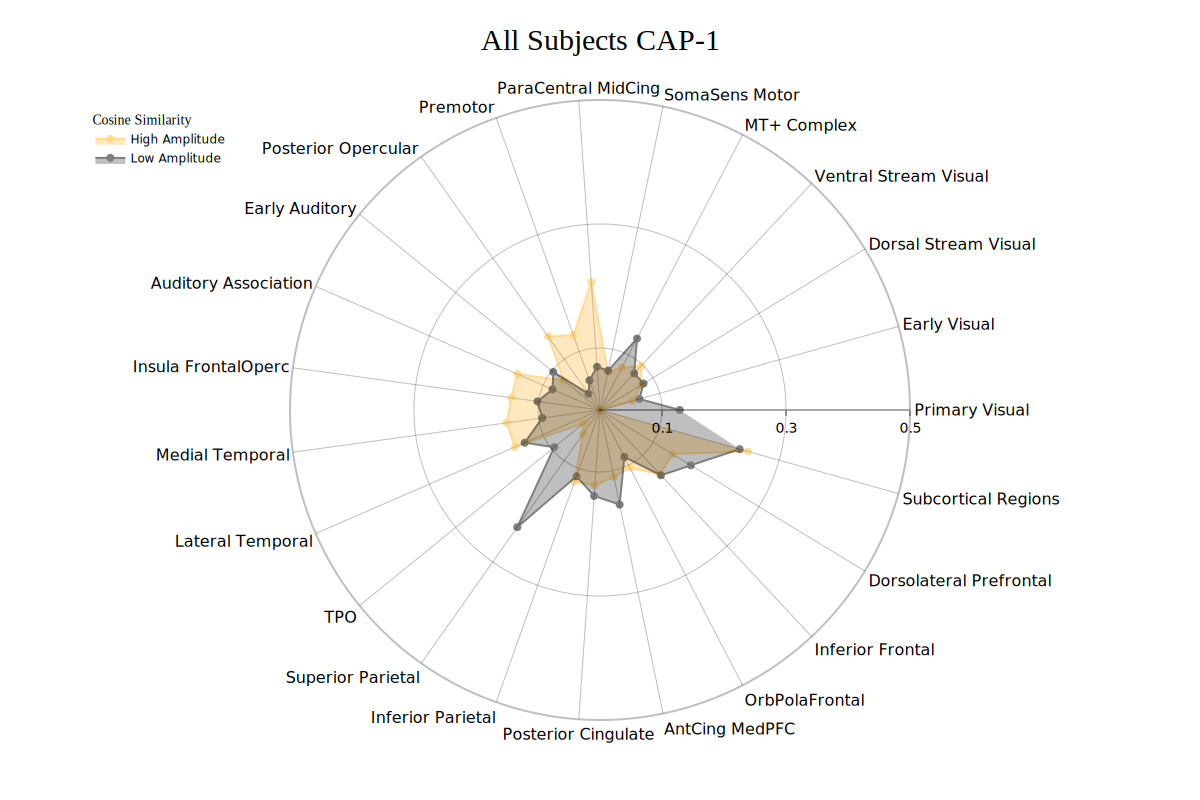

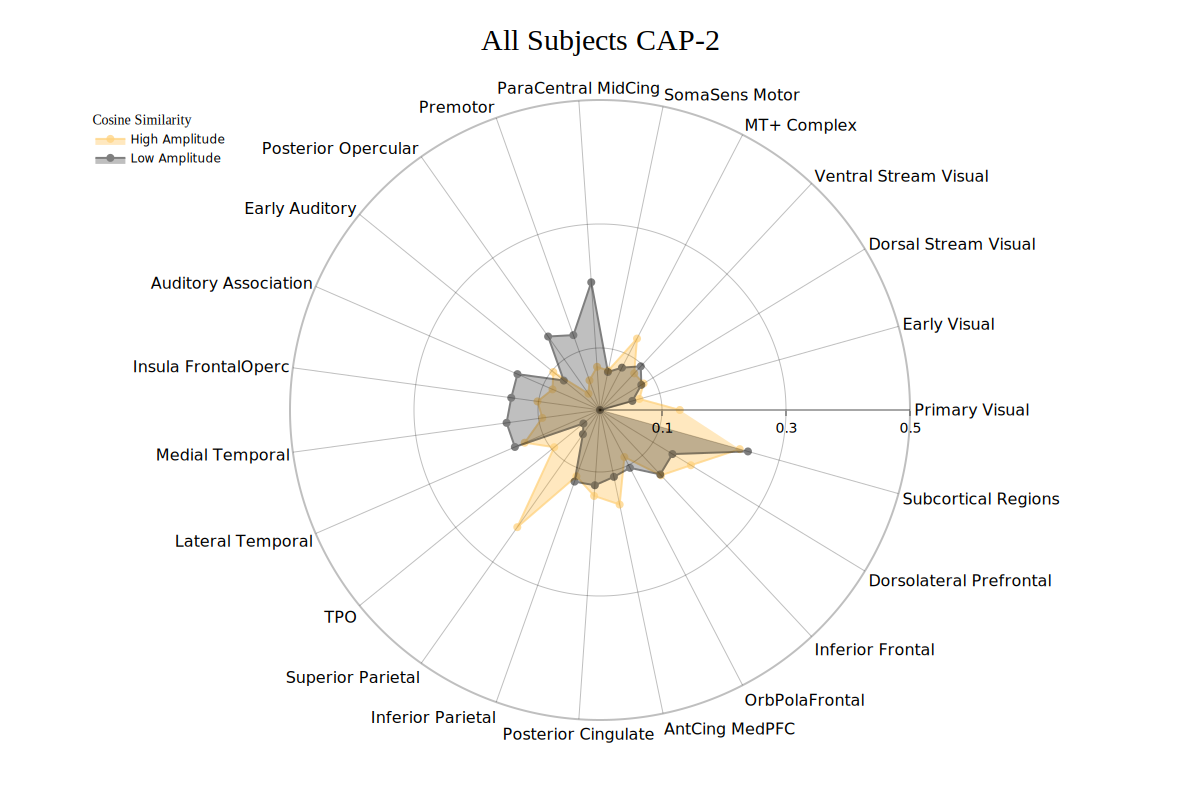

In [36]:
radialaxis = {
    "showline": True,
    "linewidth": 2,
    "linecolor": "rgba(0, 0, 0, 0.25)",
    "gridcolor": "rgba(0, 0, 0, 0.25)",
    "ticks": "outside",
    "tickfont": {"size": 14, "color": "black"},
    "range": [0, 0.5],
    "tickvals": [0.1, "", 0.3, "", 0.5],
}

color_discrete_map = {
    "High Amplitude": "rgba(255, 165, 0, 0.75)",
    "Low Amplitude": "black",
}

cap_analysis.caps2radar(
    radialaxis=radialaxis,
    fill="toself",
    color_discrete_map=color_discrete_map,
    use_scatterpolar=True,
    output_dir=output_dir,
    as_html=True,
)

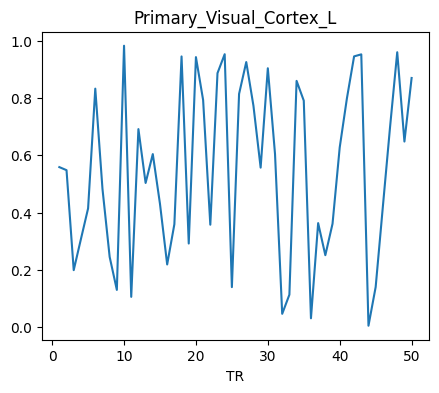

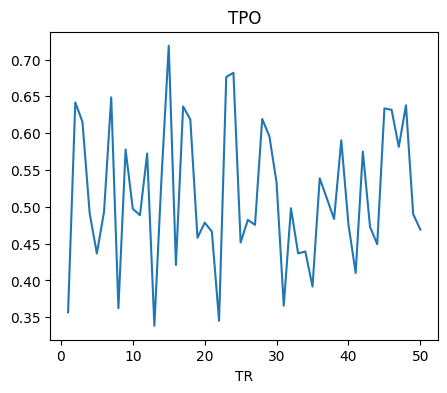

In [37]:
extractor.parcel_approach = os.path.join(output_dir, "HCPex_dict.pkl")

# Can also just set it
# extractor = TimeseriesExtractor(parcel_approach=os.path.join(output_dir,"neurocaps_demo", "HCPex_dict.pkl"))

# Subject timeseries also acts as a setter if the `visualize_bold` method needs to be used
extractor.subject_timeseries = subject_timeseries

with open(os.path.join(output_dir, "sample_for_neurocaps_demo_timeseries_HCPex.pkl"), "wb") as f:
    joblib.dump(subject_timeseries, f)

extractor.subject_timeseries = os.path.join(
    output_dir, "sample_for_neurocaps_demo_timeseries_HCPex.pkl"
)

extractor.visualize_bold(
    subj_id="01",
    run=1,
    roi_indx=0,
    figsize=(5, 4),
    output_dir=output_dir,
    filename="test_bold_for_neurocaps",
)

extractor.visualize_bold(subj_id="01", run=1, region="TPO", figsize=(5, 4))

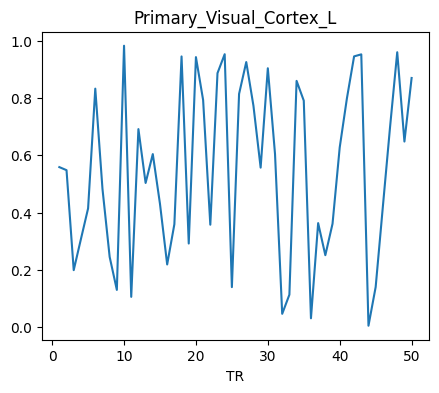

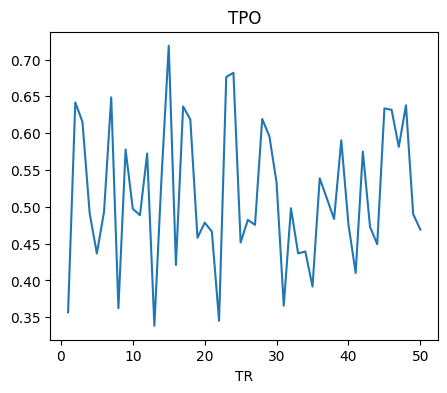

In [38]:
extractor.parcel_approach = os.path.join(output_dir, "HCPex_dict.pkl")

# Can also just set it
# extractor = TimeseriesExtractor(parcel_approach=os.path.join(output_dir,"neurocaps_demo", "HCPex_dict.pkl"))

# Subject timeseries also acts as a setter if the `visualize_bold` method needs to be used
extractor.subject_timeseries = subject_timeseries

with open(os.path.join(output_dir, "sample_for_neurocaps_demo_timeseries_HCPex.pkl"), "wb") as f:
    joblib.dump(subject_timeseries, f)

extractor.subject_timeseries = os.path.join(
    output_dir, "sample_for_neurocaps_demo_timeseries_HCPex.pkl"
)

extractor.visualize_bold(
    subj_id="01",
    run=1,
    roi_indx=0,
    figsize=(5, 4),
    output_dir=output_dir,
    filename="test_bold_for_neurocaps",
)

extractor.visualize_bold(subj_id="01", run=1, region="TPO", figsize=(5, 4))

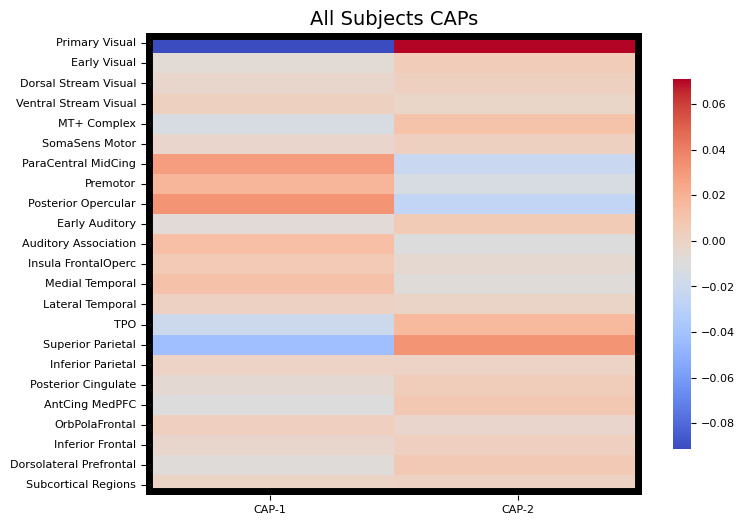

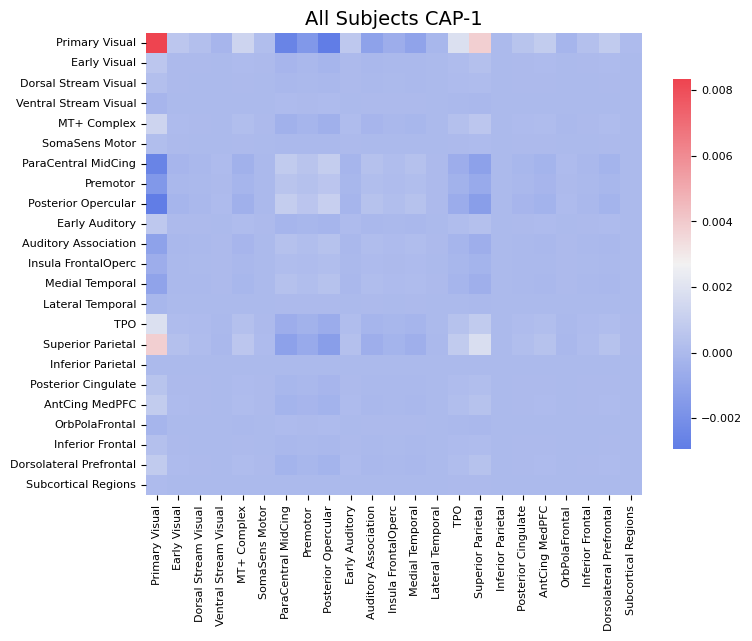

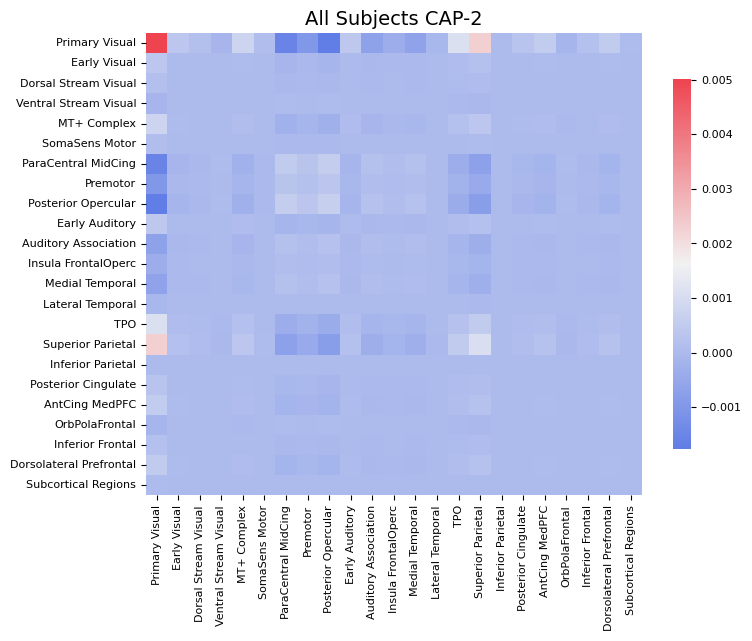

In [39]:
import seaborn as sns

sns.diverging_palette(145, 300, s=60, as_cmap=True)

palette = sns.diverging_palette(260, 10, s=80, l=55, n=256, as_cmap=True)

cap_analysis.caps2plot(visual_scope="regions", plot_options="heatmap", borderwidths=10)

cap_analysis.caps2plot(
    visual_scope="regions",
    plot_options="outer_product",
    subplots=False,
    fontsize=14,
    tight_layout=False,
    xlabel_rotation=90,
    hspace=0.3,
    cmap=palette,
    output_dir=output_dir,
)

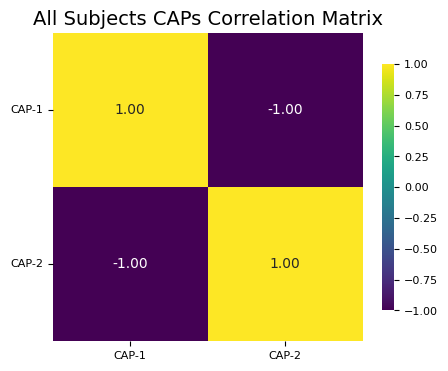

,Subject_ID,Group,Run,CAP-1,CAP-2
0,01,All Subjects,run-continuous,3.150000,4.243902
1,02,All Subjects,run-continuous,2.947368,4.947368
2,03,All Subjects,run-continuous,3.818182,5.117647
3,04,All Subjects,run-continuous,3.384615,4.307692
4,05,All Subjects,run-continuous,3.365854,4.050000
5,06,All Subjects,run-continuous,4.000000,4.000000
6,07,All Subjects,run-continuous,3.047619,4.000000
7,08,All Subjects,run-continuous,3.750000,3.846154
8,09,All Subjects,run-continuous,3.116279,3.860465
9,10,All Subjects,run-continuous,3.222222,5.111111


In [40]:
cap_analysis.caps2corr(annot=True, cmap="viridis", fmt=".2f", figsize=(5, 4), output_dir=output_dir)

outputs = cap_analysis.calculate_metrics(
    subject_timeseries=os.path.join(output_dir, "sample_for_neurocaps_demo_timeseries_HCPex.pkl"),
    tr=2,
    continuous_runs=True,
    metrics=["persistence", "transition_probability"],
    output_dir=output_dir,
)

outputs["persistence"]

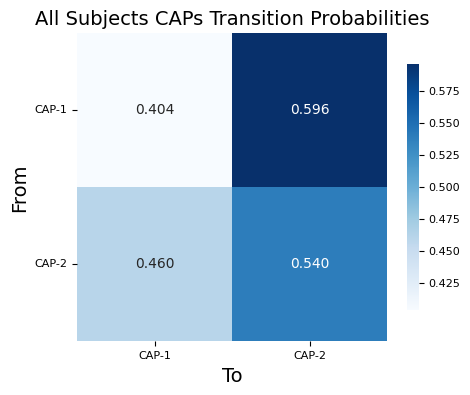

,CAP-1,CAP-2
From/To,,
CAP-1,0.403780,0.596220
CAP-2,0.460261,0.539739


In [41]:
trans_df = transition_matrix(
    trans_dict=outputs["transition_probability"],
    annot=True,
    fmt=".3f",
    return_df=True,
    figsize=(5, 4),
    cmap="Blues",
)

trans_df["All Subjects"]

<font size="6">Using KNN to Fix Surface Plot Visualization Issues </font>

<font size="3">This is primarily for parcellations outside of Schaefer and AAL. If you notice that your surface plots are sparse due to having many unassigned cortical surface voxels, there is a `knn_dict` parameter in both `self.caps2surf` and `self.caps2niftis`, which uses the Schaefer atlas as a reference atlas to determine the background boundaries so that k-nearest neighbors interpolation can be used. The sub-keys are "k" and "resolution_mm" for the resolution of Schaefer to use as the reference. **This process may take a few minutes depending on your computer**.</font>

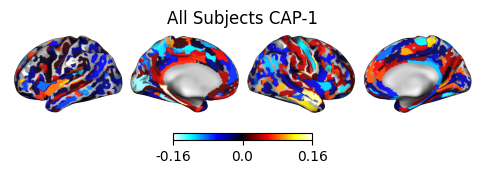

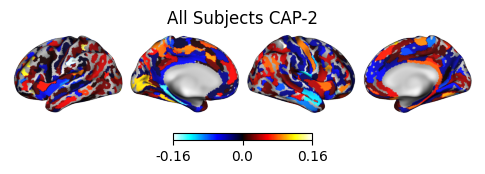

[06/13/25 05:47:34] WARNING  2025-06-13 05:47:34,244 neurocaps.analysis.cap [WARNING] 'reference_atlas' ]8;id=769205;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap.py\cap.py]8;;\:]8;id=55544;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap.py#2485\2485]8;;\
                             not specified in `knn_dict`. The default reference atlas is 'Schaefer'.               

                    WARNING  2025-06-13 05:47:34,247 neurocaps.analysis.cap [WARNING] Defaulting to 1mm ]8;id=505547;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap.py\cap.py]8;;\:]8;id=264799;file://C:\Users\donis\Github\neurocaps\neurocaps\analysis\cap.py#2493\2493]8;;\
                             resolution for the Schaefer atlas since 'resolution_mm' was not specified             
                             in `knn_dict`.                                                                        

Generating Surface Plots [GROUP: All Subjects]:   0%|          | 0/2 [00:00<?, ?it/s]

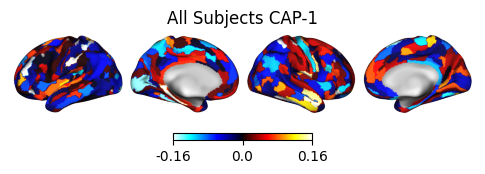

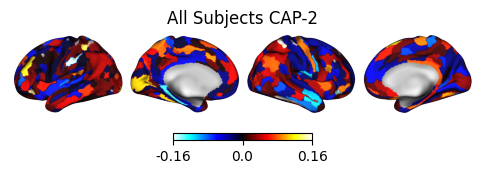

In [42]:
# Plotting with caps2surf; showing original and version using knn to reduce gaps
cap_analysis.caps2surf(size=(500, 100), layout="row", method="nearest", color_range=[-0.16, 0.16])

cap_analysis.caps2surf(
    size=(500, 100),
    layout="row",
    method="nearest",
    knn_dict={"k": 5, "method": "majority_vote"},
    color_range=[-0.16, 0.16],
    save_stat_maps=True,
    output_dir=output_dir,
    progress_bar=True,
)

Quick example using Schaefer 4s for "Custom" ``parcel_approach``.

<font size="3">Visualizing CAPs as surface plots using `self.caps2surf` method.</font>

In [60]:
# Fetching atlas NiFTI image and labels from Github
if sys.platform != "win32":
    cmd = [
        [
            "wget",
            "-q",
            "-P",
            output_dir,
            "https://github.com/PennLINC/AtlasPack/raw/main/atlas-4S156Parcels_dseg.tsv",
        ],
    ]
else:
    cmd = [
        [
            "curl",
            "-L",
            "-o",
            f"{output_dir}\\atlas-4S156Parcels_dseg.tsv",
            "https://github.com/PennLINC/AtlasPack/raw/main/atlas-4S156Parcels_dseg.tsv",
        ],
    ]

for command in cmd:
    subprocess.run(command, check=True)

# Creating custom parcel approach dictionary and extracting timeseries
parcel_approach = {"Custom": {}}

# Setting the "nodes", which is needed for "TimeseriesExtractor.visualize_bold"; Getting nodes that don't correspond to background label
parcel_approach["Custom"]["nodes"] = pd.read_csv(
    os.path.join(output_dir, "atlas-4S156Parcels_dseg.tsv"),
    sep="\t",
)["label"].values

# Needed for many plotting methods; Setting the region names and their corresponding indices in the nodes list,
# in this case it is just the label id - 1
parcel_approach["Custom"]["regions"] = {
    "Visual": [*range(0, 9), *range(50, 58)],
    "SMN": [*range(9, 15), *range(58, 66)],
    "DAN": [*range(15, 23), *range(66, 73)],
    "VAN": [*range(23, 30), *range(73, 78)],
    "Limbic":[*range(30, 33), *range(78, 80)],
    "Cont": [*range(33, 37), *range(80, 89)],
    "DMN": [*range(37, 50), *range(89, 100)],
    "Subcortical": [*range(100, 146)],
    "Cerebellar": [*range(100, 156)],
}


In [61]:
sub_ids = [f"0{x}" if x < 10 else x for x in range(1, 11)]
subject_timeseries = {
    str(x): {f"run-{y}": np.random.rand(50, 156) for y in range(1, 4)} for x in sub_ids
}

cap_analysis.parcel_approach = parcel_approach
cap_analysis.get_caps(subject_timeseries=subject_timeseries, n_clusters=3)


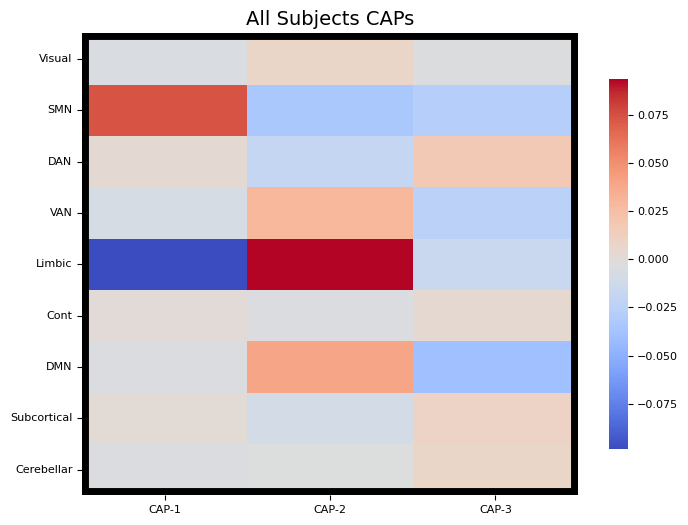

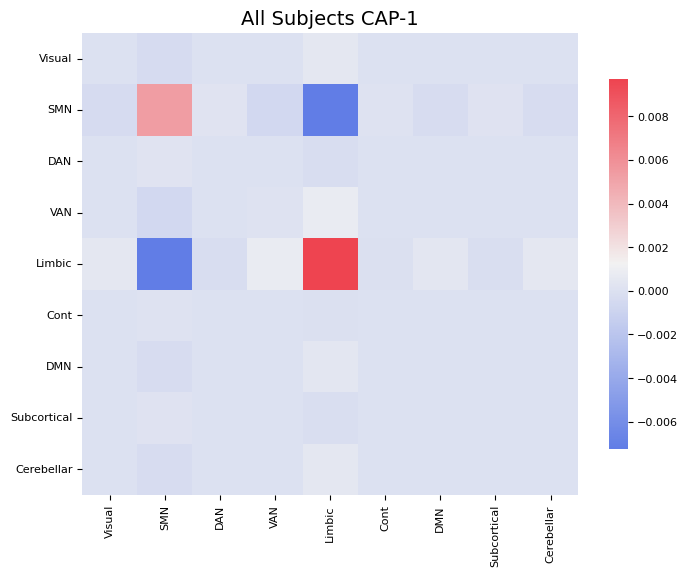

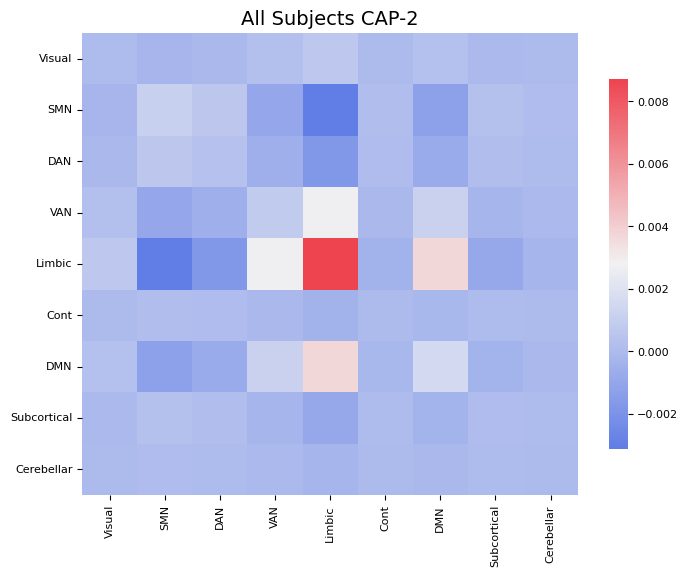

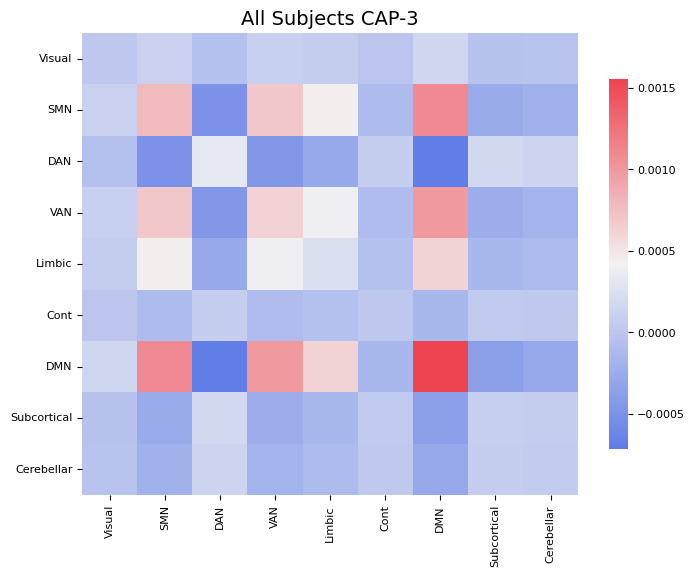

In [62]:
import seaborn as sns

sns.diverging_palette(145, 300, s=60, as_cmap=True)

palette = sns.diverging_palette(260, 10, s=80, l=55, n=256, as_cmap=True)

cap_analysis.caps2plot(visual_scope="regions", plot_options="heatmap", borderwidths=10)

cap_analysis.caps2plot(
    visual_scope="regions",
    plot_options="outer_product",
    subplots=False,
    fontsize=14,
    tight_layout=False,
    xlabel_rotation=90,
    hspace=0.3,
    cmap=palette,
    output_dir=output_dir,
)

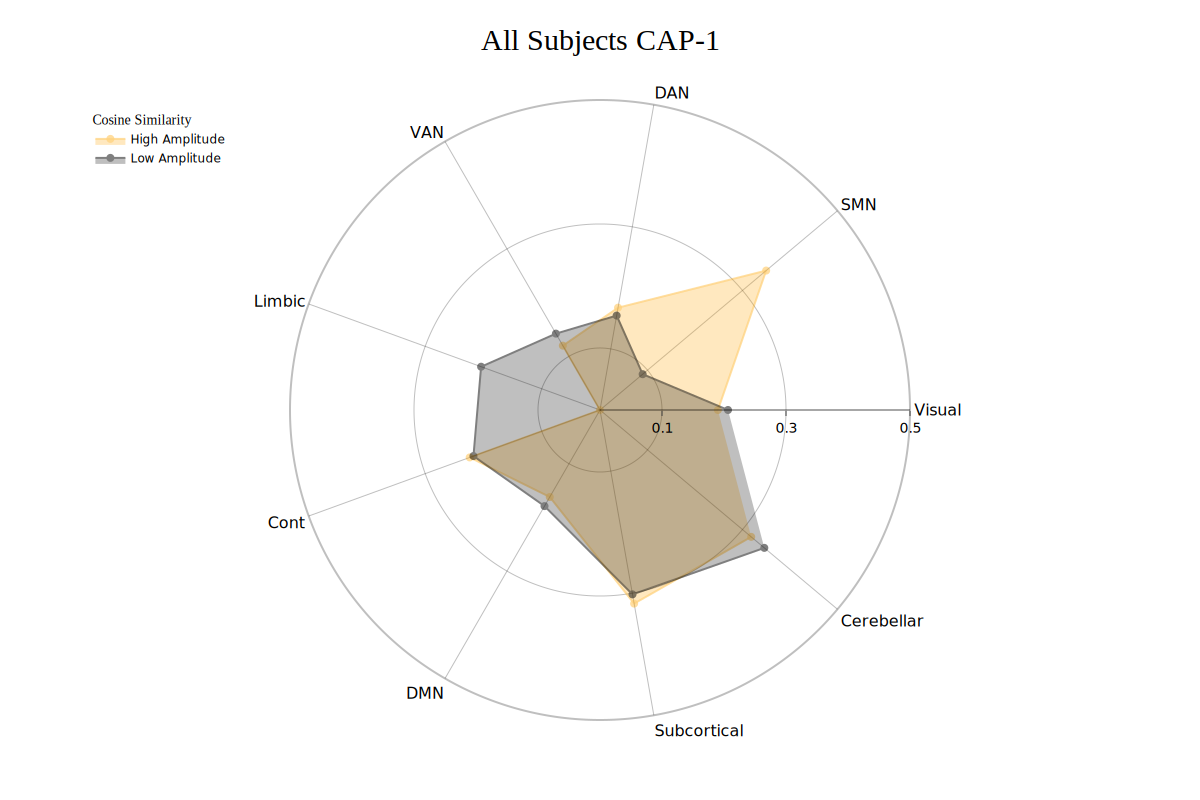

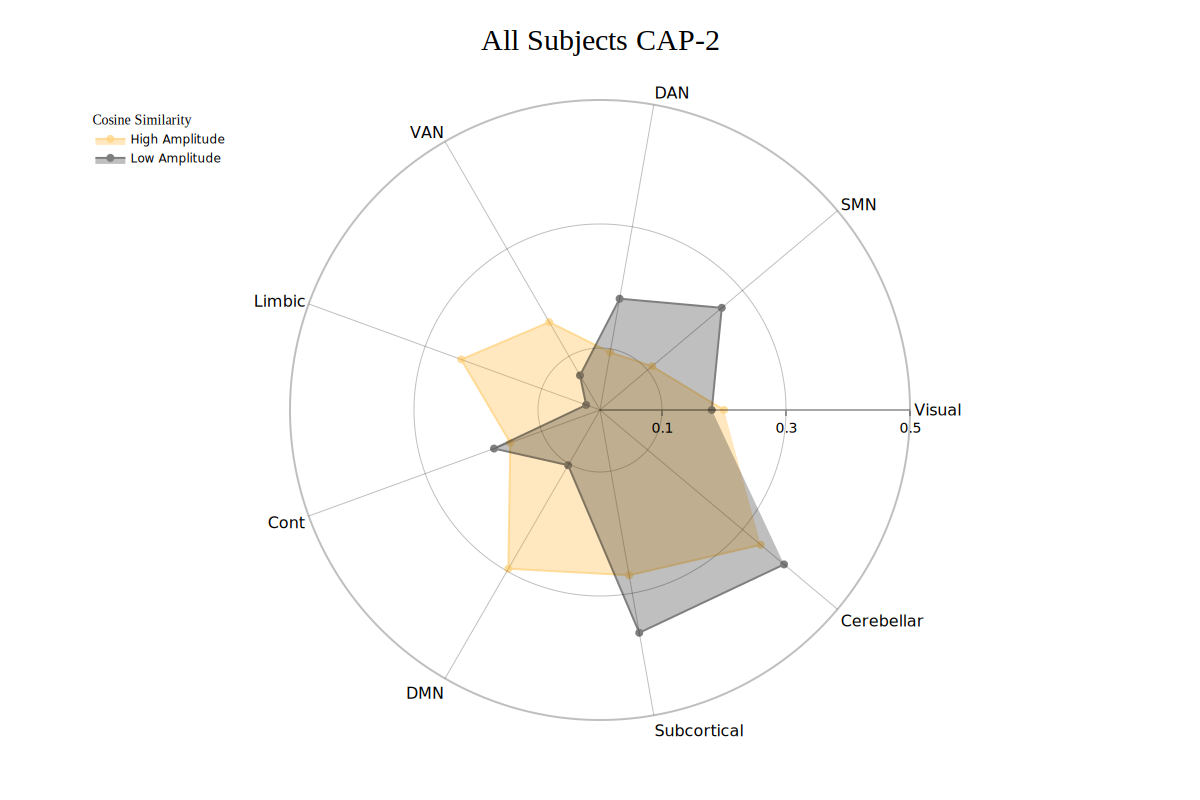

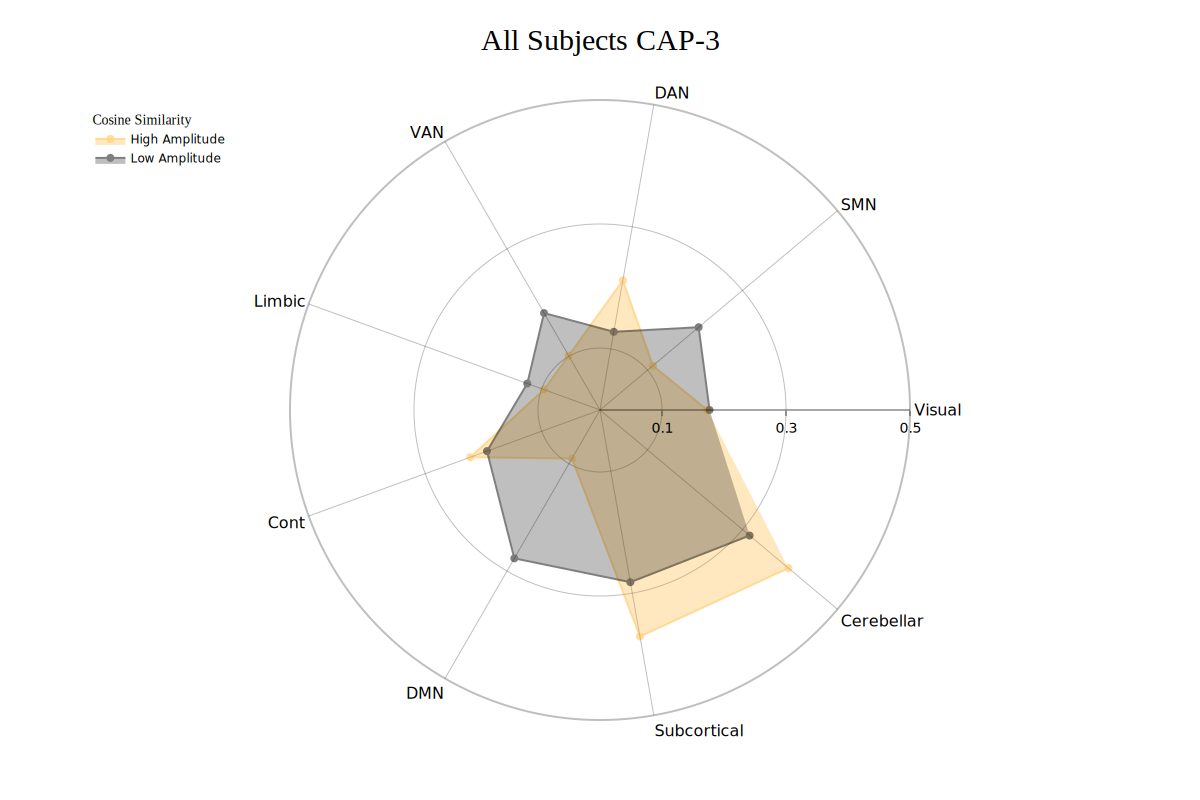

In [63]:
radialaxis = {
    "showline": True,
    "linewidth": 2,
    "linecolor": "rgba(0, 0, 0, 0.25)",
    "gridcolor": "rgba(0, 0, 0, 0.25)",
    "ticks": "outside",
    "tickfont": {"size": 14, "color": "black"},
    "range": [0, 0.5],
    "tickvals": [0.1, "", 0.3, "", 0.5],
}

color_discrete_map = {
    "High Amplitude": "rgba(255, 165, 0, 0.75)",
    "Low Amplitude": "black",
}

cap_analysis.caps2radar(
    radialaxis=radialaxis,
    fill="toself",
    color_discrete_map=color_discrete_map,
    use_scatterpolar=True,
    output_dir=output_dir,
    as_html=True,
)

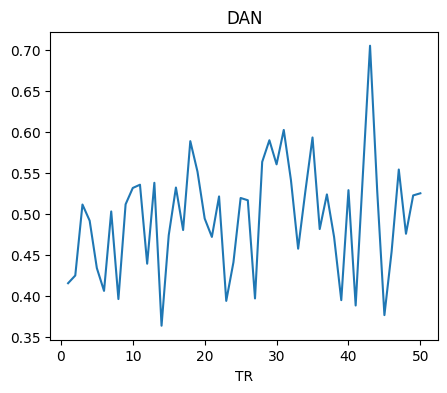

In [64]:
extractor.subject_timeseries = subject_timeseries
extractor.parcel_approach = parcel_approach
extractor.visualize_bold(subj_id="01", run=1, region="DAN", figsize=(5, 4))

<font size="6">Types </font>

<font size="3">Type definitions are offered in the `neurocaps.typing` module to assist in building the correct dictionary structure for parcellation configurations,
parcellation approaches, and subject timeseries when using a static type checker such as [Pylance](https://marketplace.visualstudio.com/items?itemName=ms-python.vscode-pylance).</font>

In [ ]:
from neurocaps.typing import *

schaefer_config: SchaeferParcelConfig = {"n_rois": 100, "yeo_networks": 7, "resolution_mm": 1}

parcel_config: ParcelConfig = {"Schaefer": schaefer_config}

# Set new parcellation configuration
extractor.parcel_approach = parcel_config

 <font size="3">Removes the files and directories generated in this demo.</font>

In [ ]:
import shutil

shutil.rmtree("neurocaps_demo", ignore_errors=True)